In [142]:
import datetime

import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns
import numpy as np

In [70]:
import lightgbm as lgb

In [2]:
INPUT_DIR = "input/"

In [18]:
df = pd.read_csv(INPUT_DIR + "44_17c-m2.csv")
df = df.drop(df.index[0])

In [19]:
df.head()

,date,gasvol,h20vol,oilvol,bhp,bht,choke,hrsonline,whp,wht,gasinjvol,h20injvol
1,11/1/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,12/1/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,13/1/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,14/1/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,15/1/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [22]:
cols = df.columns[1:]
df[cols] = df[cols].astype("float")

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2005-11-01 to 2018-09-19
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       5000 non-null   object 
 1   gasvol     4718 non-null   float64
 2   h20vol     0 non-null      float64
 3   oilvol     0 non-null      float64
 4   bhp        0 non-null      float64
 5   bht        0 non-null      float64
 6   choke      4713 non-null   float64
 7   hrsonline  4736 non-null   float64
 8   whp        4712 non-null   float64
 9   wht        4710 non-null   float64
 10  gasinjvol  5000 non-null   float64
 11  h20injvol  5000 non-null   float64
dtypes: float64(11), object(1)
memory usage: 507.8+ KB


In [51]:
df.describe()

,gasvol,h20vol,oilvol,bhp,bht,choke,hrsonline,whp,wht,gasinjvol,h20injvol
count,4.718000e+03,0.0,0.0,0.0,0.0,4713.000000,4736.000000,4712.000000,4710.000000,5000.0,5000.0
mean,4.868614e+05,NaN,NaN,NaN,NaN,69.555548,19.452998,30.257789,35.420913,0.0,0.0
std,5.571981e+05,NaN,NaN,NaN,NaN,41.801659,8.501019,20.863258,12.410636,0.0,0.0
min,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,-20.000000,0.0,0.0
25%,9.798312e+04,NaN,NaN,NaN,NaN,17.100000,20.200000,19.200000,31.000000,0.0,0.0
50%,2.836414e+05,NaN,NaN,NaN,NaN,96.900000,24.000000,25.200000,38.800000,0.0,0.0
75%,7.028457e+05,NaN,NaN,NaN,NaN,98.800000,24.000000,32.100000,44.200000,0.0,0.0
max,2.737552e+06,NaN,NaN,NaN,NaN,124.000000,25.000000,190.300000,73.900000,0.0,0.0


In [23]:
df.index = pd.to_datetime(df["date"])

In [55]:
cond = (df['hrsonline'] == 24) | (df['hrsonline'] == 0)
df_ext = df[cond]

<AxesSubplot:xlabel='date'>

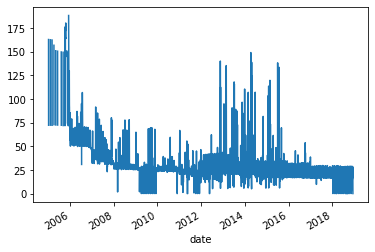

In [57]:
df_ext['whp'].plot()

<AxesSubplot:xlabel='date'>

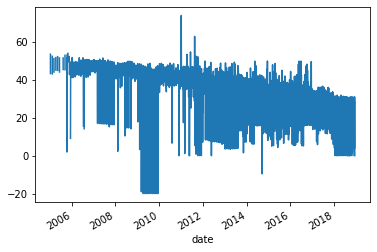

In [58]:
df_ext['wht'].plot()

<AxesSubplot:xlabel='date'>

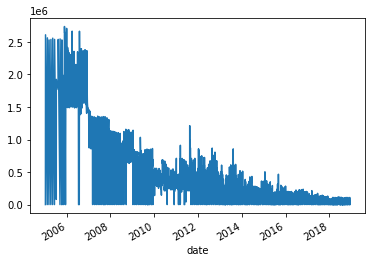

In [59]:
df_ext['gasvol'].plot()

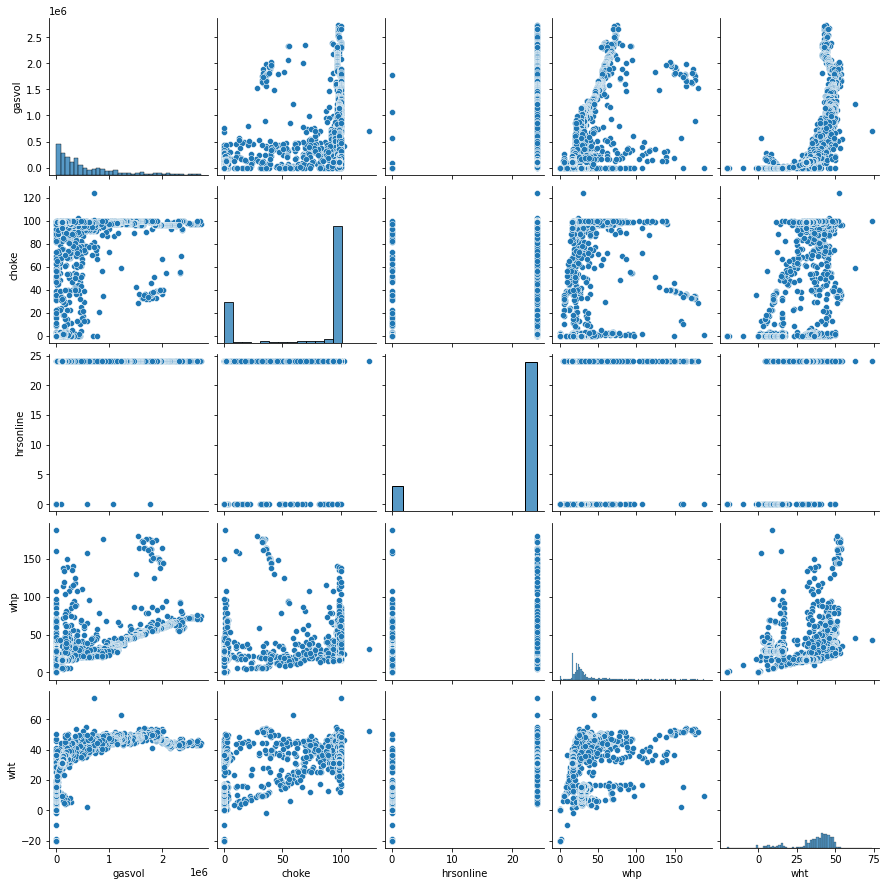

In [63]:
plot_cols = ["gasvol", "choke", "hrsonline", "whp", "wht"]

sns.pairplot(df_ext[plot_cols])

In [203]:
df_clearn = df_ext[plot_cols].dropna().copy()
df_emp = pd.DataFrame(index = pd.date_range(df_ext.index.min(), df_ext.index.max())).reset_index(drop=False).rename(columns={"index":"date"})
df_clearn = pd.merge(df_emp, df_clearn, on='date',  how='left').fillna(0).set_index('date')

In [204]:
df_clearn

,gasvol,choke,hrsonline,whp,wht
date,,,,,
2005-01-10,0.000000e+00,0.0,0.0,0.0,0.0
2005-01-11,1.790574e+06,35.8,24.0,163.0,53.5
2005-01-12,2.610155e+06,97.4,24.0,72.3,43.3
2005-01-13,0.000000e+00,0.0,0.0,0.0,0.0
2005-01-14,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2018-12-05,0.000000e+00,0.0,0.0,0.0,0.0
2018-12-06,1.086710e+05,98.8,24.0,16.7,31.0
2018-12-07,0.000000e+00,0.0,0.0,27.3,12.0


In [205]:
target = ['gasvol']
features = ['choke', 'hrsonline', 'whp', 'wht', 'year', 'week', 'dayofweek', 'cum_days']


df_clearn['year'] = df_clearn.index.isocalendar().year.astype("int")
df_clearn['week'] = df_clearn.index.isocalendar().week.astype("int")
df_clearn['dayofweek'] = df_clearn.index.dayofweek.astype("int")
df_clearn['cum_days'] = (df_clearn['hrsonline'] == 24).cumsum()

for l in range(1,3):
    df_clearn[f'vol_shift_{l}d'] = df['gasvol'].shift(l).bfill()
    features.append(f'vol_shift_{l}d')


df_clearn.head()

,gasvol,choke,hrsonline,whp,wht,year,week,dayofweek,cum_days,vol_shift_1d,vol_shift_2d
date,,,,,,,,,,,
2005-01-10,0.000,0.0,0.0,0.0,0.0,2005,2,0,0,0.000,0.000
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,2005,2,1,1,1661387.510,1540979.527
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,2005,2,2,2,2627748.967,2642370.828
2005-01-13,0.000,0.0,0.0,0.0,0.0,2005,2,3,2,0.000,0.000
2005-01-14,0.000,0.0,0.0,0.0,0.0,2005,2,4,2,0.000,0.000


In [209]:
df_clearn.shape

(5082, 11)

In [206]:
valid_start = datetime.datetime(2017, 1, 1)
test_start = datetime.datetime(2018, 1, 1)
test_end = datetime.datetime(2018, 9, 1)

In [210]:
df_train = df_clearn[df_clearn.index < valid_start]
df_valid = df_clearn[(df_clearn.index >= valid_start) & (df_clearn.index < test_start)]
df_test = df_clearn[(df_clearn.index >= test_start) & (df_clearn.index < test_end)]

In [211]:
lgb_train = lgb.Dataset(df_train[features], df_train[target].apply(np.log1p))
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target].apply(np.log1p))
lgb_test = lgb.Dataset(df_test[features], df_test[target].apply(np.log1p))
# 評価基準を設定する 
params = {'metric' : 'rmse'}

In [212]:
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 4374, number of used features: 10
[LightGBM] [Info] Start training from score 8.961107
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 2.14992
[20]	valid_0's rmse: 0.769785
[30]	valid_0's rmse: 0.33096
[40]	valid_0's rmse: 0.238734
[50]	valid_0's rmse: 0.221732
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.219341


In [213]:
df_eval = df_test.copy()
df_eval['pred'] = model.predict(df_test[features])

In [214]:
def plot_prediction(df_eval):
    cond = df_eval['hrsonline'] == 24
    
    actual = df_eval[cond]['gasvol']
    pred = df_eval[cond]['pred'].apply(np.expm1)
    
    mape = (np.abs(pred - actual) / actual * 100).mean()

#     actual = df_eval['gasvol']
#     pred = df_eval['pred'].apply(np.expm1)
    
    actual.plot(label='actual', marker='.' )
    pred.plot(label=f'predict, MAPE:{mape:.2f} %', linestyle='-.')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

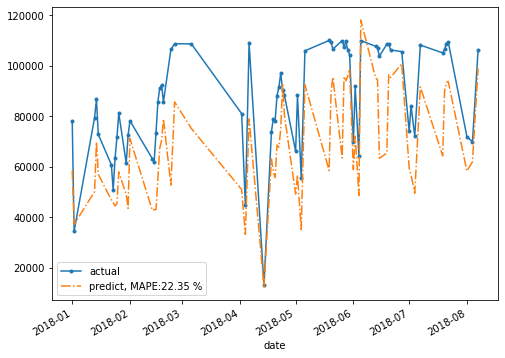

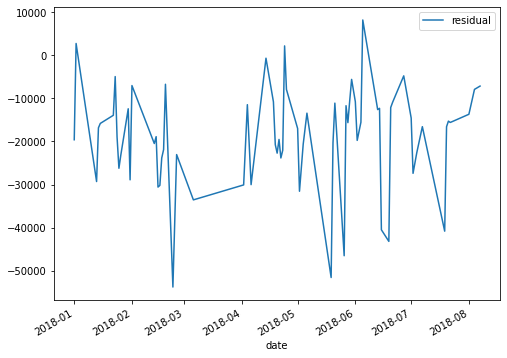

In [215]:
plot_prediction(df_eval)